# 1. Dataset Preparation

In [322]:
import pandas as pd
import scipy as sp
import numpy as np
import nltk
from nltk.corpus import reuters
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import seaborn as sns
import matplotlib.pyplot as plt

In [288]:
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [289]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
import matplotlib as plt
#nltk.download()

In [290]:
documents = reuters.fileids()
print(str(len(documents)) + " documents")
train_docs = list(filter(lambda doc: doc.startswith("train"), documents))
print(str(len(train_docs))+ ' total train docs')
test_docs = list(filter(lambda doc: doc.startswith("test"),documents))
print(str(len(test_docs)) + ' total test docs')
categories = reuters.categories()
print(str(len(categories)) + " total categories")
train_y = [reuters.categories(i)[0] for i in train_docs]
test_y = [reuters.categories(i)[0] for i in test_docs]

10788 documents
7769 total train docs
3019 total test docs
90 total categories


# Describe the dataset

In [291]:
train_label =np.array(train_y)
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_coded = encoder.fit_transform(train_y)
test_y_coded = encoder.fit_transform(test_y)
trainDF = pd.DataFrame()

In [292]:
train_n_paragraph, train_texts = [],[]

for i in train_docs:
    train_texts.append(''.join(reuters.raw(i).split('\n')))
    train_n_paragraph.append(reuters.raw(i).count('\n'))
    

In [293]:
trainDF['texts']=train_texts
trainDF['n_paragraph']=train_n_paragraph

In [294]:
test_n_paragraph, test_texts = [],[]

for i in test_docs:
    test_texts.append(''.join(reuters.raw(i).split('\n')))
    test_n_paragraph.append(reuters.raw(i).count('\n'))    

In [295]:
testDF = pd.DataFrame()
testDF['texts']=test_texts
testDF['n_paragraph']=test_n_paragraph

In [296]:
dataset=pd.concat([trainDF,testDF])

In [297]:
dataset.reset_index(inplace=True)

In [298]:
cachedStopWords = stopwords.words("english")
cachedStopWords.extend(['said','will'])

In [299]:
dataset.head()

,index,texts,n_paragraph
0,0,BAHIA COCOA REVIEW Showers continued througho...,58
1,1,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,27
2,2,N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...,12
3,3,NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...,17
4,4,ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...,13


### Remove stop word

In [300]:
cachedStopWords = stopwords.words("english")
cachedStopWords.extend(['said','will'])
dataset['texts_r_sw']=dataset['texts'].apply(lambda x: [ word  for word in x.split() if word not in cachedStopWords])
dataset['sw_percentage']=dataset['texts_r_sw'].apply(len)/dataset['texts'].apply(lambda x: len(x.split()))

### Word Stemming

In [301]:
stemming=PorterStemmer()
dataset['texts_sw_st']=dataset['texts_r_sw'].apply(lambda x: [stemming.stem(i) for i in x])


### Word tokenization

In [302]:
dataset['texts_tk']=dataset['texts_sw_st'].apply(lambda x: word_tokenize(' '.join(x))) 

0    [bahia, cocoa, review, shower, continu, throug...
1    [comput, termin, system, &, lt, ;, cpml, >, co...
2    [n.z, ., trade, bank, deposit, growth, rise, s...
3    [nation, amus, again, up, viacom, &, lt, ;, vi...
4    [roger, &, lt, ;, rog, >, see, 1st, qtr, net, ...
Name: texts_tk, dtype: object

# 2. Feature Engeering 

#2.1 Count Vectors as features
#2.2 TF-IDF Vectors as features
    Word level
    N-Gram level
    Character level
#2.3 Word Embeddings as features
#2.4 Text / NLP based features
#2.5 Topic Models as features

## 2.1 Count Vectors as features

Create count vectors from raw data and tokenized data respectively.

In [17]:
#create a count vectorizer object from raw data
count_vect = CountVectorizer(analyzer='word', token_pattern = r'\w{1,}')
count_vect.fit(dataset['texts'])
#transform the training and testing data using count vectorizer object
xtrain_count = count_vect.transform(trainDF['texts'])
xtest_count = count_vect.transform(testDF['texts'])

In [18]:
#len(count_vect.get_feature_names())
#len(trainDF['texts'])

In [19]:
#generate count vectors from tokenized data
dataset['texts_tk']=dataset['texts_tk'].apply(' '.join)
count_vect_tk = CountVectorizer(analyzer='word', token_pattern = r'\w{1,}')
count_vect_tk.fit(dataset['texts_tk'])
xtrain_count_tk = count_vect_tk.transform(dataset['texts_tk'][:7769])
xtest_count_tk = count_vect_tk.transform(dataset['texts_tk'][7769:])

<7769x28633 sparse matrix of type '<class 'numpy.int64'>'
	with 495829 stored elements in Compressed Sparse Row format>

In [20]:
#len(count_vect_tk.get_feature_names())
#xtrain_count_tk.toarray().shape

## 2.2TF-IDF Vectors as features

Generate TF-IDF vectors based on raw data and tokenized data from three aspects:
#Word Level TF-IDF
#N-gram Level TF-IDF
#Character Level TF-IDF

In [21]:
# Word level TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataset['texts'])
xtrain_tfidf = tfidf_vect.transform(trainDF['texts'])
xtest_tfidf = tfidf_vect.transform(testDF['texts'])

In [22]:
## Character level TF-IDF
tfidf_vect_char = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}',ngram_range=(2,3))
tfidf_vect_char.fit(dataset['texts'])
xtrain_tfidf_char = tfidf_vect_char.transform(trainDF['texts'])
xtest_tfidf_char = tfidf_vect_char.transform(testDF['texts'])
#len(tfidf_vect_char.get_feature_names())

In [ ]:
#tfidf_vect_tk.get_feature_names()
#xtrain_tfidf.toarray().shape

In [23]:
# N-gram level TF-IDF
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(dataset['texts'])
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(trainDF['texts'])
xtest_tfidf_ngram =tfidf_vect_ngram.transform(testDF['texts'])

Generate TF-IDF vectors from tokenized data.

In [24]:
# Word level TF-IDF
tfidf_vect_tk = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=30000)
tfidf_vect_tk.fit(dataset['texts_tk'])
xtrain_tfidf_tk = tfidf_vect.transform(dataset['texts_tk'][:7769])
xtest_tfidf_tk = tfidf_vect.transform(dataset['texts_tk'][7769:])

In [25]:
tfidf_vect_ngram_tk = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3))
tfidf_vect_ngram_tk.fit(dataset['texts_tk'])
xtrain_tfidf_ngram_tk = tfidf_vect_ngram.transform(dataset['texts_tk'][:7769])
xtest_tfidf_ngram_tk =tfidf_vect_ngram.transform(dataset['texts_tk'][7769:])
#len(tfidf_vect_ngram_tk.get_feature_names())

In [26]:
## Character level TF-IDF
tfidf_vect_char_tk = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}',ngram_range=(2,3))
tfidf_vect_char_tk.fit(dataset['texts_tk'])
xtrain_tfidf_char_tk = tfidf_vect_char.transform(dataset['texts_tk'][:7769])
xtest_tfidf_char_tk = tfidf_vect_char.transform(dataset['texts_tk'][7769:])
#len(tfidf_vect_char_tk.get_feature_names())

## 2.3 Word Embedding

In [ ]:
'''
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/Users/Hans/Documents/Wei/Springboard_bootcamp/project1/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(dataset['texts'])
word_index = token.word_index
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(trainDF['texts']), maxlen=7000)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(testDF['texts']), maxlen=7000)
# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
'''

"\n# load the pre-trained word-embedding vectors \nembeddings_index = {}\nfor i, line in enumerate(open('/Users/Hans/Documents/Wei/Springboard_bootcamp/project1/wiki-news-300d-1M.vec')):\n    values = line.split()\n    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')\n# create a tokenizer \ntoken = text.Tokenizer()\ntoken.fit_on_texts(dataset['texts'])\nword_index = token.word_index\n# convert text to sequence of tokens and pad them to ensure equal length vectors \ntrain_seq_x = sequence.pad_sequences(token.texts_to_sequences(trainDF['texts']), maxlen=7000)\ntest_seq_x = sequence.pad_sequences(token.texts_to_sequences(testDF['texts']), maxlen=7000)\n# create token-embedding mapping\nembedding_matrix = numpy.zeros((len(word_index) + 1, 300))\nfor word, i in word_index.items():\n    embedding_vector = embeddings_index.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[i] = embedding_vector\n"

## 2.4 Text/NLP based features

#Noun Count
#Verb Count
#Abjective Count
#Adverb Count
#Pronoun Count

In [27]:
dataset['char_count']=dataset['texts'].apply(len)

In [28]:
dataset['word_count']=dataset['texts'].apply(lambda x: len(x.split()))

In [29]:
dataset['word_density']=dataset['char_count']/(dataset['word_count']+1)

In [30]:
dataset['punctuation_count']=dataset['texts'].apply(lambda x: len(''.join(_ for _ in x if _ in string.punctuation)))

In [31]:
dataset['title_word_count']=dataset['texts'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

In [32]:
dataset['upper_case_word_count']=dataset['texts'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [33]:
#nltk.download()

In [34]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

dataset['noun_count'] = dataset['texts'].apply(lambda x: check_pos_tag(x, 'noun'))
dataset['verb_count'] = dataset['texts'].apply(lambda x: check_pos_tag(x, 'verb'))
dataset['adj_count'] = dataset['texts'].apply(lambda x: check_pos_tag(x, 'adj'))
dataset['adv_count'] = dataset['texts'].apply(lambda x: check_pos_tag(x, 'adv'))
dataset['pron_count'] = dataset['texts'].apply(lambda x: check_pos_tag(x, 'pron'))

In [35]:
tn_features=['noun_count','verb_count','adj_count','adv_count','pron_count']

In [36]:
dataset[tn_features].head()

,noun_count,verb_count,adj_count,adv_count,pron_count
0,188,66,30,14,3
1,95,28,15,3,9
2,36,10,5,2,2
3,59,24,4,4,3
4,37,13,10,5,3


## 2.5 Combine count vector and word level tfidf vector

In [ ]:
#combine count vector and word level tfidf vector
xtrain_cb=sp.hstack((xtrain_count_tk.toarray(),xtrain_tfidf.toarray()))
xtest_cb=sp.hstack((xtest_count_tk.toarray(),xtest_tfidf.toarray()))
xtrain_df=pd.DataFrame(xtrain_cb)
xtrain_df[tn_features]=dataset[tn_features][:7769]
xtest_df=pd.DataFrame(xtest_cb)
xtest_df[tn_features]=dataset[tn_features][7769:]
from sklearn.preprocessing import StandardScaler
stdscaler=StandardScaler()
xtrain_stdscaler=stdscaler.fit_transform(xtrain_df)
xtest_stdscaler=stdscaler.transform(xtest_df)

# 3 Model Building

In [55]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, test_y), predictions

## 3.1 Naive Bayes

In [97]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy) 

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_char, train_y, xtest_tfidf_char)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  (0.7833719774759854, array(['trade', 'grain', 'crude', ..., 'crude', 'crude', 'gold'],
      dtype='<U15'))
NB, WordLevel TF-IDF:  (0.7413050679032792, array(['trade', 'acq', 'crude', ..., 'crude', 'acq', 'acq'], dtype='<U15'))
NB, N-Gram Vectors:  (0.7452798940046373, array(['trade', 'acq', 'trade', ..., 'interest', 'crude', 'acq'],
      dtype='<U15'))
NB, CharLevel Vectors:  (0.5763497846969196, array(['acq', 'acq', 'acq', ..., 'acq', 'acq', 'acq'], dtype='<U15'))


In [137]:
# Naive Bayes on combined Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_cb, train_y, xtest_cb)
print("NB, CB Vectors: ", accuracy)

NB, CB Vectors:  (0.7936402782378271, array(['trade', 'grain', 'crude', ..., 'crude', 'crude', 'gold'],
      dtype='<U15'))


In [98]:
'''
accuracy = train_model(naive_bayes.MultinomialNB(), cf_xtrain_try, train_y, cf_xtest_try)
print("NB, Count Vectors: ", accuracy)
'''

'\naccuracy = train_model(naive_bayes.MultinomialNB(), cf_xtrain_try, train_y, cf_xtest_try)\nprint("NB, Count Vectors: ", accuracy)\n'

In [66]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count_tk, train_y, xtest_count_tk)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_tk, train_y, xtest_tfidf_tk)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_tk, train_y, xtest_tfidf_ngram_tk)
print("NB, N-Gram Vectors: ", accuracy) 

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_char_tk, train_y, xtest_tfidf_char_tk)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.7943027492547201
NB, WordLevel TF-IDF:  0.7161311692613448
NB, N-Gram Vectors:  0.6674395495197085
NB, CharLevel Vectors:  0.5763497846969196


## 3.2 Linear Classifier

In [99]:
from sklearn.multiclass import OneVsRestClassifier

In [100]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_char, train_y, xtest_tfidf_char)
print("LR, CharLevel Vectors: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  (0.8830738655183835, array(['trade', 'corn', 'crude', ..., 'interest', 'ipi', 'gold'],
      dtype='<U15'))
LR, WordLevel TF-IDF:  (0.8423318979794634, array(['trade', 'grain', 'crude', ..., 'crude', 'trade', 'gold'],
      dtype='<U15'))
LR, N-Gram Vectors:  (0.7631666114607486, array(['trade', 'acq', 'trade', ..., 'interest', 'gnp', 'acq'],
      dtype='<U15'))
LR, CharLevel Vectors:  (0.8082146406094733, array(['trade', 'grain', 'crude', ..., 'acq', 'gnp', 'acq'], dtype='<U15'))


In [ ]:
#accuracy,predictions = train_model(linear_model.LogisticRegression(), cf_xtrain_try, train_y, cf_xtest_try)
#print("LR, Count Vectors: ", accuracy)

In [64]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count_tk, train_y, xtest_count_tk)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_tk, train_y, xtest_tfidf_tk)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_tk, train_y, xtest_tfidf_ngram_tk)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_char_tk, train_y, xtest_tfidf_char_tk)
print("LR, CharLevel Vectors: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  0.8830738655183835
LR, WordLevel TF-IDF:  0.8343822457767472
LR, N-Gram Vectors:  0.7224246439218284
LR, CharLevel Vectors:  0.8098708181517059


## 3.3 SVM 

In [102]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM, N-Gram Vectors:  (0.35872805564756544, array(['earn', 'earn', 'earn', ..., 'earn', 'earn', 'earn'], dtype='<U15'))


In [103]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_count, train_y, xtest_count)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  (0.546538588936734, array(['trade', 'acq', 'acq', ..., 'earn', 'earn', 'earn'], dtype='<U15'))


In [104]:
accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xtest_tfidf)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  (0.35872805564756544, array(['earn', 'earn', 'earn', ..., 'earn', 'earn', 'earn'], dtype='<U15'))


In [105]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_char, train_y, xtest_tfidf_char)
print("SVM, Char Vectors: ", accuracy)

SVM, Char Vectors:  (0.35872805564756544, array(['earn', 'earn', 'earn', ..., 'earn', 'earn', 'earn'], dtype='<U15'))


In [42]:
# SVM on Combined Vectors
accuracy = train_model(svm.SVC(), xtrain_cb, train_y, xtest_cb)
print("SVM, CB Vectors: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM, CB Vectors:  (0.5521695925803246, array(['trade', 'earn', 'earn', ..., 'earn', 'earn', 'earn'], dtype='<U15'))


## 3.4 Bagging Model

In [106]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print("RF, Count Vectors: ", accuracy) 

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  (0.7360052997681351, array(['acq', 'earn', 'acq', ..., 'acq', 'gnp', 'crude'], dtype='<U15'))


/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, WordLevel TF-IDF:  (0.7654852600198742, array(['trade', 'grain', 'crude', ..., 'acq', 'trade', 'acq'],
      dtype='<U15'))


In [107]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_char, train_y, xtest_tfidf_char)
print("RF, char TF-IDF Vectors: ", accuracy) 

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print("RF, ngram TF-IDF: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, char TF-IDF Vectors:  (0.7237495859556144, array(['trade', 'acq', 'acq', ..., 'acq', 'coffee', 'acq'], dtype='<U15'))


/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, ngram TF-IDF:  (0.7429612454455118, array(['trade', 'acq', 'bop', ..., 'crude', 'crude', 'acq'], dtype='<U15'))


In [ ]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count_tk, train_y, xtest_count_tk)
print("RF, Count Vectors: ", accuracy) 

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_tk, train_y, xtest_tfidf_tk)
print("RF, WordLevel TF-IDF: ", accuracy)

In [48]:
xtrain_stdscaler=xtrain_stdscaler.astype('float64')
xtest_stdscaler=xtest_stdscaler.astype('float64')

In [50]:
# RF on Combined Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_cb, train_y, xtest_cb)
print("RF, CB Vectors: ", accuracy) 

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, CB Vectors:  (0.7578668433256045, array(['trade', 'crude', 'crude', ..., 'ship', 'gnp', 'acq'], dtype='<U15'))


## 3.5 Boosting Model

In [108]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xtest_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xtest_tfidf_ngram.tocsc())
print("Xgb, N-gram TF-IDF Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_char.tocsc(), train_y, xtest_tfidf_char.tocsc())
print("Xgb, Char TF-IDF Vectors: ", accuracy)

Xgb, Count Vectors:  (0.8691619741636304, array(['trade', 'grain', 'crude', ..., 'ship', 'ipi', 'gold'],
      dtype='<U15'))
Xgb, WordLevel TF-IDF:  (0.8678370321298443, array(['trade', 'grain', 'crude', ..., 'ship', 'ipi', 'gold'],
      dtype='<U15'))


In [93]:
# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_char.tocsc(), train_y, xtest_tfidf_char.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

Xgb, CharLevel Vectors:  0.8618747929778072


In [146]:
# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xtest_tfidf_ngram.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

Xgb, CharLevel Vectors:  (0.758198078834051, array(['trade', 'grain', 'earn', ..., 'acq', 'gnp', 'earn'], dtype='<U15'))


In [ ]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count_tk.tocsc(), train_y, xtest_count_tk.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_tk.tocsc(), train_y, xtest_tfidf_tk.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

In [96]:
xtrain_tfidf_ngram.shape

(7769, 5000)

In [ ]:
#Extereme Gradient Boosting  on Combined Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_stdscaler, train_y, xtest_stdscaler)
print("Xgb, CB Vectors: ", accuracy)

# 3.6 Runtime of each model

In [110]:
'''
# Naive Bayes on Count Vectors
%timeit accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print("NB, Count Vectors: ", accuracy)
# Linear Classifier on Count Vectors
%timeit accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print("LR, Count Vectors: ", accuracy)
# SVM on Ngram Level TF IDF Vectors
%timeit accuracy = train_model(svm.SVC(), xtrain_count, train_y, xtest_count)
print("SVM, N-Gram Vectors: ", accuracy)
# RF on Count Vectors
%timeit accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print("RF, Count Vectors: ", accuracy) 
# Extereme Gradient Boosting on Count Vectors
%timeit accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)
'''

131 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
NB, Count Vectors:  (0.8598873799271282, array(['trade', 'grain', 'crude', ..., 'ship', 'ipi', 'gold'],
      dtype='<U15'))


In [114]:
#test entire runtime of models
import timeit
import time

In [115]:
start_time=time.clock()
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print(accuracy)
print('navie bayes:', time.clock()-start_time)

/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


(0.7833719774759854, array(['trade', 'grain', 'crude', ..., 'crude', 'crude', 'gold'],
      dtype='<U15'))
navie bayes: 0.22664500000064436


/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [116]:
start_time=time.clock()
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print("LR, Count Vectors: ", accuracy)
print('Logistic Regression:', time.clock()-start_time)

/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  (0.8830738655183835, array(['trade', 'corn', 'crude', ..., 'interest', 'ipi', 'gold'],
      dtype='<U15'))
Logistic Regression: 31.596119999998336


/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [163]:
start_time=time.clock()
accuracy = train_model(svm.SVC(), xtrain_count, train_y, xtest_count)
print("SVM: ", accuracy)
print('SVM:', time.clock()-start_time)

/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM:  (0.546538588936734, array(['trade', 'acq', 'acq', ..., 'earn', 'earn', 'earn'], dtype='<U15'))
SVM: 62.44756000000052


/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [117]:
start_time=time.clock()
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print("RF, Count Vectors: ", accuracy) 
print('Random Forest:', time.clock()-start_time)

/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  (0.725405763497847, array(['trade', 'acq', 'acq', ..., 'oilseed', 'earn', 'acq'], dtype='<U15'))
Random Forest: 2.075265000001309


/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [118]:
start_time=time.clock()
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)
print('Random Forest:', time.clock()-start_time)

/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Xgb, Count Vectors:  (0.8691619741636304, array(['trade', 'grain', 'crude', ..., 'ship', 'ipi', 'gold'],
      dtype='<U15'))
Random Forest: 930.2755670000006


/Users/Hans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


# 3.7 Performance of different datasets on Logistic Regression

In [131]:
classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_count_tk,train_y)
predict_y=classifier.predict(xtest_count_tk)
print('accuracy of count vectors:',metrics.accuracy_score(predict_y, test_y))

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy of combined vectors: 0.8830738655183835


In [132]:
classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_tfidf,train_y)
predict_y=classifier.predict(xtest_tfidf)
print('accuracy of word level TF-IDF vectors:',metrics.accuracy_score(predict_y, test_y))

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy of word level TF-IDF vectors: 0.8423318979794634


In [134]:
classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_tfidf_ngram_tk,train_y)
predict_y=classifier.predict(xtest_tfidf_ngram_tk)
print('accuracy of n-gram level TF-IDF vectors:',metrics.accuracy_score(predict_y, test_y))

accuracy of n-gram level TF-IDF vectors: 0.7224246439218284


In [135]:
classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_tfidf_char_tk,train_y)
predict_y=classifier.predict(xtest_tfidf_char_tk)
print('accuracy of character level TF-IDF vectors:',metrics.accuracy_score(predict_y, test_y))

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy of character level TF-IDF vectors: 0.8098708181517059


In [136]:
classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_cb,train_y)
predict_y=classifier.predict(xtest_cb)
print('accuracy of combined vectors:',metrics.accuracy_score(predict_y, test_y))

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy of combined vectors: 0.8834051010268301


# 3.7 Parameters optimization

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score

In [40]:
classifier = linear_model.LogisticRegression()

scores=cross_val_score(classifier, xtrain_count_tk, train_y,cv=3)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [41]:
print('Accuracy : %0.4f (+/- %0.4f)'%(scores.mean(), scores.std()) )

Accuracy : 0.8823 (+/- 0.0041)


In [50]:
parameters={'penalty':['l1','l2']}
classifier=linear_model.LogisticRegression()
clf=GridSearchCV(classifier,parameters)
clf.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "t

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [51]:
clf.cv_results_

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.

{'mean_fit_time': array([ 8.36401502, 17.98295474]),
 'std_fit_time': array([0.91948319, 1.99728253]),
 'mean_score_time': array([0.01823568, 0.0145913 ]),
 'std_score_time': array([0.00276311, 0.00064422]),
 'param_penalty': masked_array(data=['l1', 'l2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'l1'}, {'penalty': 'l2'}],
 'split0_test_score': array([0.87781596, 0.87667048]),
 'split1_test_score': array([0.8867414 , 0.88364901]),
 'split2_test_score': array([0.88451034, 0.88646118]),
 'mean_test_score': array([0.88299652, 0.88222422]),
 'std_test_score': array([0.00380438, 0.00412263]),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_train_score': array([0.99359223, 0.99669903]),
 'split1_train_score': array([0.99498263, 0.99710536]),
 'split2_train_score': array([0.99596619, 0.9986554 ]),
 'mean_train_score': array([0.99484702, 0.9974866 ]),
 'std_train_score': array([0.0009739 , 0.00084295])}

In [81]:
parameters={'solver':['saga','liblinear']}
classifier=linear_model.LogisticRegression(penalty='l1')
clf=GridSearchCV(classifier,parameters)
clf.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['saga', 'liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
clf.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [82]:
clf.cv_results_

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.

{'mean_fit_time': array([193.06635571,   7.95897539]),
 'std_fit_time': array([10.44365341,  0.82080417]),
 'mean_score_time': array([0.02850755, 0.01509404]),
 'std_score_time': array([0.00221109, 0.00098568]),
 'param_solver': masked_array(data=['saga', 'liblinear'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'solver': 'saga'}, {'solver': 'liblinear'}],
 'split0_test_score': array([0.85987018, 0.87819779]),
 'split1_test_score': array([0.8755315, 0.8867414]),
 'split2_test_score': array([0.8692938 , 0.88490051]),
 'mean_test_score': array([0.8681941 , 0.88325396]),
 'std_test_score': array([0.0064563 , 0.00368272]),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_train_score': array([0.96252427, 0.99359223]),
 'split1_train_score': array([0.96159784, 0.99498263]),
 'split2_train_score': array([0.96215905, 0.99596619]),
 'mean_train_score': array([0.96209372, 0.99484702]),
 'std_train_score': array([0.00038103, 0.000973

In [83]:
parameters={'max_iter':[10,25,50,100]}
classifier=linear_model.LogisticRegression(penalty='l1', solver='liblinear')
clf=GridSearchCV(classifier,parameters)
clf.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterat

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [10, 25, 50, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [84]:
clf.cv_results_

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.

{'mean_fit_time': array([4.50870101, 8.48050427, 8.01873366, 7.7501177 ]),
 'std_fit_time': array([0.30023785, 1.0160402 , 0.34569673, 0.4556137 ]),
 'mean_score_time': array([0.01651835, 0.01508466, 0.01664639, 0.01454631]),
 'std_score_time': array([0.00137936, 0.00079605, 0.00061372, 0.00112196]),
 'param_max_iter': masked_array(data=[10, 25, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_iter': 10},
  {'max_iter': 25},
  {'max_iter': 50},
  {'max_iter': 100}],
 'split0_test_score': array([0.88048874, 0.87781596, 0.87781596, 0.87819779]),
 'split1_test_score': array([0.88635485, 0.8867414 , 0.8867414 , 0.8867414 ]),
 'split2_test_score': array([0.88373   , 0.88451034, 0.88412017, 0.88451034]),
 'mean_test_score': array([0.88351139, 0.88299652, 0.88286781, 0.88312524]),
 'std_test_score': array([0.00240584, 0.00380438, 0.00375729, 0.00362936]),
 'rank_test_score': array([1, 3, 4, 2], dtype=int32),
 'spl

In [48]:
parameters={'max_iter':[15,25,50,100,150]}
classifier=linear_model.LogisticRegression(penalty='l1',solver='liblinear')
clf=GridSearchCV(classifier,parameters)
clf.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iteratio

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [15, 25, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
clf.cv_results_

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.

{'mean_fit_time': array([ 8.09885176, 12.75348465, 20.79175599, 20.38137086, 21.77115695]),
 'std_fit_time': array([0.1241074 , 1.42168695, 1.91909065, 1.25224531, 1.62721373]),
 'mean_score_time': array([0.03559144, 0.03228307, 0.03875669, 0.02942332, 0.02937659]),
 'std_score_time': array([0.00162385, 0.00213146, 0.00968347, 0.00073564, 0.0010093 ]),
 'param_max_iter': masked_array(data=[15, 25, 50, 100, 150],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_iter': 15},
  {'max_iter': 25},
  {'max_iter': 50},
  {'max_iter': 100},
  {'max_iter': 150}],
 'split0_test_score': array([0.87437953, 0.87552501, 0.87628866, 0.87590683, 0.87590683]),
 'split1_test_score': array([0.88403556, 0.88403556, 0.88210282, 0.88248937, 0.88248937]),
 'split2_test_score': array([0.88099883, 0.87943816, 0.881389  , 0.88060866, 0.88060866]),
 'mean_test_score': array([0.87977861, 0.87964989, 0.87990732, 0.87964989, 0.87964989]),
 

In [93]:
parameters={'max_iter':[10,15,25]}
classifier=linear_model.LogisticRegression(penalty='l1',solver='liblinear')
clf=GridSearchCV(classifier,parameters)
clf.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterat

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [10, 15, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [92]:
clf.cv_results_

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Hans/anaconda3/lib/python3.

{'mean_fit_time': array([ 5.96287696,  8.42496792, 17.1116794 ]),
 'std_fit_time': array([0.55649173, 0.76225767, 1.01050275]),
 'mean_score_time': array([0.03806329, 0.03936179, 0.03805995]),
 'std_score_time': array([0.00584693, 0.01390107, 0.00566382]),
 'param_max_iter': masked_array(data=[10, 15, 25],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_iter': 10}, {'max_iter': 15}, {'max_iter': 25}],
 'split0_test_score': array([0.87056128, 0.87437953, 0.87552501]),
 'split1_test_score': array([0.88171627, 0.88403556, 0.88403556]),
 'split2_test_score': array([0.87904799, 0.88099883, 0.87943816]),
 'mean_test_score': array([0.87707556, 0.87977861, 0.87964989]),
 'std_test_score': array([0.00477078, 0.00404379, 0.00348645]),
 'rank_test_score': array([3, 1, 2], dtype=int32),
 'split0_train_score': array([0.98563107, 0.99417476, 0.99650485]),
 'split1_train_score': array([0.98205326, 0.99440371, 0.99671941]),
 'split2_train

In [90]:
accuracy = train_model(linear_model.LogisticRegression(penalty='l1',max_iter=10), xtrain_count_tk, train_y, xtest_count_tk)
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  (0.8913547532295462, array(['trade', 'grain', 'crude', ..., 'earn', 'ipi', 'gold'],
      dtype='<U15'))


In [60]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count_tk, train_y, xtest_count_tk)
print("LR, Count Vectors: ", accuracy)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  (0.8830738655183835, array(['trade', 'grain', 'crude', ..., 'ship', 'ipi', 'gold'],
      dtype='<U15'))


# 3.8 Finalize the model

In [409]:
import pickle

In [415]:
model=linear_model.LogisticRegression(penalty='l1', max_iter=10)

In [416]:
model.fit(xtrain_count_tk,train_y)

/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Hans/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [417]:
model_name = 'news_classification_logisticreg_031520.sav'

In [429]:
from joblib import dump,load

In [430]:
from sklearn.externals import joblib

In [431]:
joblib.dump(model,'news_classification_logisticreg_031520.pkl')

['news_classification_logisticreg_031520.pkl']

In [410]:
prediction=model.predict(xtest_count_tk)

# 4.Model Evaluation

In [97]:
accuracy=metrics.accuracy_score(prediction, test_y)

In [404]:
confusion_metrics = metrics.confusion_matrix(test_y,prediction,labels=unique_label)

In [405]:
confusion_metrics

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4]])

In [406]:
unique_label=list(set(train_y))

In [407]:
confusion_metrics=pd.DataFrame(confusion_metrics,columns=unique_label)

In [408]:
confusion_metrics.head()

,retail,gas,sun-oil,copra-cake,nzdlr,acq,interest,nat-gas,strategic-metal,silver,...,rubber,copper,ipi,dfl,carcass,pet-chem,orange,palm-oil,soy-oil,income
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
confusion_metrics.insert(0,'label',unique_label)

In [171]:
confusion_metrics.set_index('label',inplace=True)

In [205]:
top10_topics=['earn','acq','crude','interest', 'money-fx', 'trade','grain','corn','dlr','money-supply']

In [180]:
cm_top10=confusion_metrics.loc[['earn','acq','crude','interest', 'money-fx', 'trade','grain','corn','dlr','money-supply'],['earn','acq','crude','interest', 'money-fx', 'trade','grain','corn','dlr','money-supply']]

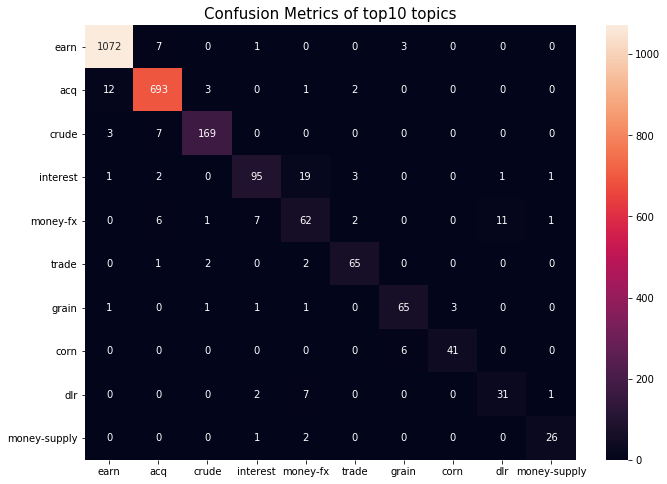

In [196]:
plt.figure(figsize=(11,8))
sns.heatmap(cm_top10,annot=True,fmt='d')
plt.title('Confusion Metrics of top10 topics', fontsize=15)
plt.ylabel(None)
plt.savefig('confusion metrics of top10 topics.png')

In [197]:
last10_topics=['castor-oil','dfl','nzdlr','copra-cake','groundnut-oil','soybean','cotton-oil','sun-oil','rand', 'platinum']

In [199]:
cm_last10=confusion_metrics.loc[last10_topics,last10_topics]

In [201]:
#cm_last10

In [202]:
middle10_topics=['instal-debt',
 'coconut',
 'silver',
 'soy-oil',
 'coconut-oil',
 'nickel',
 'l-cattle',
 'cpu',
 'rape-oil',
 'dmk']

In [203]:
cm_middel10=confusion_metrics.loc[middle10_topics,middle10_topics]

In [204]:
cm_middel10

,instal-debt,coconut,silver,soy-oil,coconut-oil,nickel,l-cattle,cpu,rape-oil,dmk
label,,,,,,,,,,
instal-debt,1,0,0,0,0,0,0,0,0,0
coconut,0,2,0,0,0,0,0,0,0,0
silver,0,0,0,0,0,0,0,0,0,0
soy-oil,0,0,0,0,0,0,0,0,0,0
coconut-oil,0,0,0,0,0,0,0,0,0,0
nickel,0,0,0,0,0,1,0,0,0,0
l-cattle,0,0,0,0,0,0,0,0,0,0
cpu,0,0,0,0,0,0,0,0,0,0
rape-oil,0,0,0,0,0,0,0,0,0,0


## 4.2 Word Cloud

In [320]:
from wordcloud import WordCloud

In [333]:
dataset_wc=pd.DataFrame(dataset['texts_tk'][:7769])

In [334]:
dataset_wc['label']=train_y

In [369]:
top10_topics

['earn',
 'acq',
 'crude',
 'interest',
 'money-fx',
 'trade',
 'grain',
 'corn',
 'dlr',
 'money-supply']

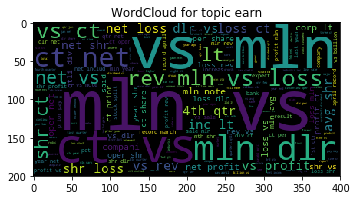

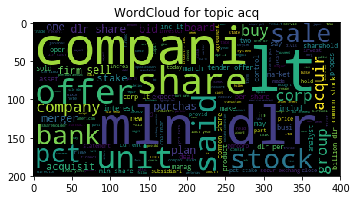

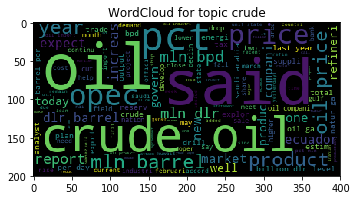

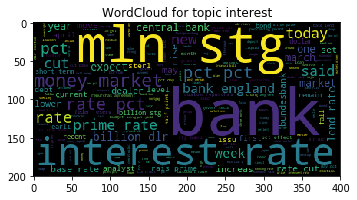

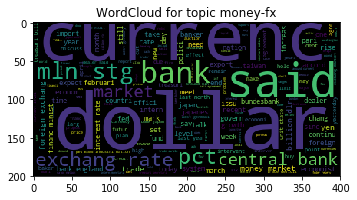

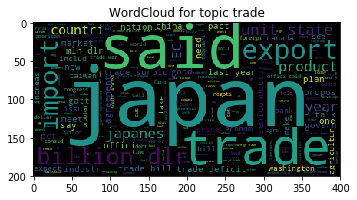

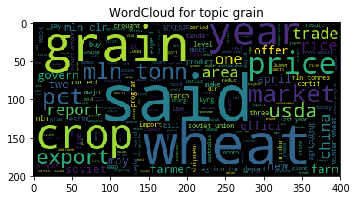

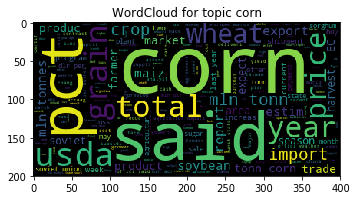

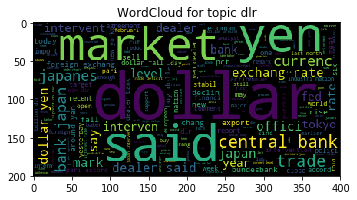

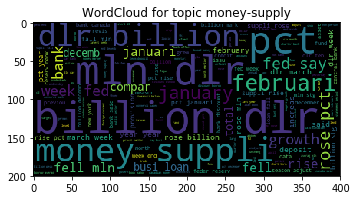

In [402]:
for topic in top10_topics:
    globals()['text_%s' %topic]=dataset_wc[dataset_wc['label']==topic].texts_tk
    globals()['texts_df_%s' %topic]=dataset_wc[dataset_wc['label']==topic]
    globals()['texts_df_%s' %topic].reset_index(inplace=True)
    globals()['%s_texts' %topic]=[]
    for i in range(len(globals()['texts_df_%s' %topic])):
        globals()['%s_texts' %topic]=globals()['%s_texts' %topic]+globals()['texts_df_%s' %topic].texts_tk[i]
    globals()['%s_texts' %topic]=' '.join(globals()['%s_texts' %topic])
    wordcloud=WordCloud().generate(globals()['%s_texts' %topic])
    plt.figure(figsize=(5.5,4))
    plt.title('WordCloud for topic %s' %topic)
    plt.imshow(wordcloud)
    wordcloud.to_file('WordCloud for topic %s .png' %topic)
        
